In [ ]:
from pycellin.classes.feature import Feature
from pycellin.classes.feature_calculator import (
    FeatureCalculatorFactory,
    FeatureCalculator,
)

#### Global node feature: *absolute age*

In [ ]:
class AbsoluteAgeCalculator(FeatureCalculator):

    def compute(self, node, lineage):
        pass

In [ ]:
feat1 = Feature(
    "absolute_age",
    "Age of the cell since the beginning of the lineage",
    "CellLineage",
    "Pycellin",
    "int",  # "float" if in_time_unit else "int",
    "frame",  # self.metadata["time_unit"] if in_time_unit else "frame",
)

In [ ]:
factory = FeatureCalculatorFactory()
factory.register_calculator(feat1, AbsoluteAgeCalculator)

#### Local node feature: *node_ID parity*

In [ ]:
class ParityCalculator(FeatureCalculator):

    def compute(self, node):
        pass

In [ ]:
feat2 = Feature(
    "node_ID_parity",
    "Parity of the node ID",
    "CellLineage",
    "Pycellin",
    "int",
)

In [ ]:
factory = FeatureCalculatorFactory()
factory.register_calculator(feat2, ParityCalculator)

### Node age

In [1]:
import pycellin as pc

In [2]:
# Path to the TrackMate XML file.
xml_path1 = "../sample_data/Ecoli_growth_on_agar_pad.xml"
xml_path2 = "../sample_data/Ecoli_growth_on_agar_pad_with_gaps.xml"


# Parse the XML file and create a Pycellin Model object
# that contains all the data from the XML file.
model1 = pc.load_TrackMate_XML(xml_path1)
model2 = pc.load_TrackMate_XML(xml_path2)

# We can display basic information about this model.
print(model1)
print(f"This model contains {model1.data.number_of_lineages()} lineages:")
for lin_ID, lineage in model1.data.cell_data.items():
    print(f"- ID {lin_ID}: {lineage}")

Model with 3 lineages.
This model contains 3 lineages:
- ID 0: CellLineage named 'Track_0' with 152 nodes and 151 edges
- ID 1: CellLineage named 'Track_1' with 189 nodes and 188 edges
- ID 2: CellLineage named 'Track_2' with 185 nodes and 184 edges


In [3]:
model1.add_pycellin_features(["absolute_age", "relative_age"])
model1.update()

In [4]:
lin0_1 = model1.data.cell_data[0]

In [5]:
lin0_1.plot(node_hover_features=["cell_ID", "absolute_age", "relative_age"])

In [6]:
model2.add_pycellin_features(["absolute_age", "relative_age"])
model2.update()
lin0_2 = model2.data.cell_data[0]
lin0_2.plot(node_hover_features=["cell_ID", "absolute_age", "relative_age"])

### EpiCure

In [1]:
import pickle

import napari
import networkx as nx
import matplotlib.pyplot as plt

import pycellin as pc

In [2]:
epi_file = "/mnt/data/Code/EpiCure_small_example/epics/013_crop_epidata.pkl"

In [3]:
with open(epi_file, "rb") as f:
    epidata = pickle.load(f)

for k, v in epidata.items():
    print(k, v)

EpiMetaData {'ScaleXY': 1, 'UnitXY': 'um', 'ScaleT': 1, 'UnitT': 'min', 'MainChannel': 0, 'Allow gaps': True, 'Verbose': 2}
Group {'paf': [48, 60, 70]}
Graph {167: [24], 172: [24], 393: [112], 397: [112], 492: [76], 505: [76], 645: [505], 658: [505], 1013: [33], 1016: [33], 1059: [916], 1066: [916], 1204: [82], 1200: [82], 1237: [674], 1240: [674], 1309: [46], 1321: [46], 1522: [1380], 1526: [1380], 208: [65, 72], 306: [167, 172], 674: [393, 397], 916: [492, 645], 1293: [32, 1016], 1345: [1200, 1204], 1380: [1237, 1240], 1465: [1321, 58]}
Events {'Points': array([[  1,  22,  30],
       [  2, 139,  68],
       [  3,  99,  19],
       [  4, 111,  15],
       [  7,  31, 212],
       [  7,  99,  19],
       [  8,  93,  43],
       [  8, 138,  68],
       [  9,  53, 197],
       [ 10, 138,  69]]), 'Props': {'id': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint16), 'label': array([  24,  112,   76,  505,   33,  916,   82,  674,   46, 1380],
      dtype=uint16), 'score': array([1, 1, 1, 1, 

In [4]:
graph_data = epidata["Graph"]
print(graph_data)

{167: [24], 172: [24], 393: [112], 397: [112], 492: [76], 505: [76], 645: [505], 658: [505], 1013: [33], 1016: [33], 1059: [916], 1066: [916], 1204: [82], 1200: [82], 1237: [674], 1240: [674], 1309: [46], 1321: [46], 1522: [1380], 1526: [1380], 208: [65, 72], 306: [167, 172], 674: [393, 397], 916: [492, 645], 1293: [32, 1016], 1345: [1200, 1204], 1380: [1237, 1240], 1465: [1321, 58]}


Using nx.from_dict_of_lists:

In [5]:
inverted_dict = {}
for key, value_list in graph_data.items():
    for value in value_list:
        if value in inverted_dict:
            inverted_dict[value].append(key)
        else:
            inverted_dict[value] = [key]

In [6]:
graph = nx.from_dict_of_lists(inverted_dict, create_using=nx.DiGraph)
print(graph)

DiGraph with 38 nodes and 36 edges


In [7]:
for n in graph.nodes:
    graph.nodes[n]["cell_ID"] = n
    graph.nodes[n]["frame"] = len(list(nx.ancestors(graph, n)))

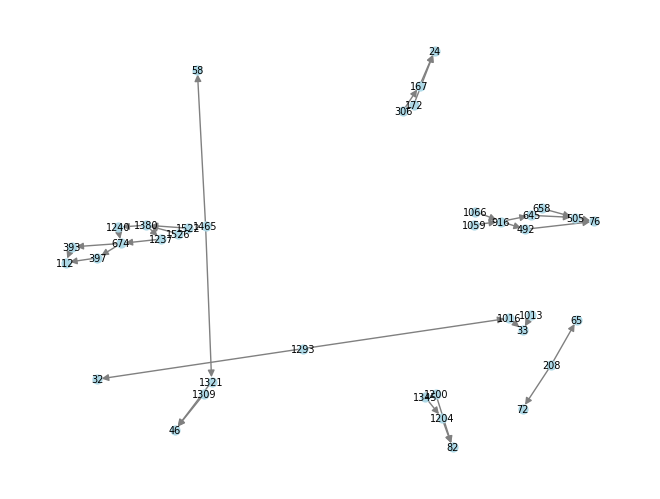

In [46]:
nx.draw(graph, with_labels=True, node_color='lightblue',
        edge_color='gray', node_size=40, font_size=7)
plt.show()

In [8]:
cellin = pc.CellLineage(graph)
cellin.plot()

Frames are incorrectly infered because of fusion events.

Manually by adding the nodes and edges:

In [36]:
nodes = set([item for key, value_list in graph_data.items()
            for item in [key] + value_list])
len(nodes)

38